In [1]:
# multi headed multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from keras.models import load_model
from keras.models import load_model
import matplotlib.pyplot as plt

import pickle
import numpy as np


Using TensorFlow backend.


In [2]:
# split a univariate dataset into train/test sets
#根据需求更改
def split_dataset(data):
	# split into standard weeks
	train, test = data[0:95016], data[95016:103776]
	# restructure into windows of 6hours data
	train = array(split(train, len(train)/24))
	test = array(split(test, len(test)/24))
	return train, test

In [3]:
# split a univariate dataset into train/test sets
#根据需求更改
#length分割长度
def split_dataset(train, test, length):
	# split into standard weeks
	#train, test = data[0:95016], data[95016:103776]
	# restructure into windows of 6hours data
	train = array(split(train, len(train)/length))
	test = array(split(test, len(test)/length))
	return train, test

In [4]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores


In [5]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [6]:
# convert history into inputs and outputs
#更改时间步长
def to_supervised(train, n_input, n_out=6):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [7]:
# train the model
#更改模型，函数返回值
#关于返回值model，还需要重点注意
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)

	# define parameters
	#verbose, epochs, batch_size = 1, 6, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# create a channel for each variable
	in_layers, out_layers = list(), list()
	for i in range(n_features):
		inputs = Input(shape=(n_timesteps,1))
		conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
		conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
		pool1 = MaxPooling1D(pool_size=2)(conv2)
		flat = Flatten()(pool1)
		# store layers
		in_layers.append(inputs)
		out_layers.append(flat)
	# merge heads
	merged = concatenate(out_layers)
	# interpretation
	dense1 = Dense(200, activation='relu')(merged)
	dense2 = Dense(100, activation='relu')(dense1)
	outputs = Dense(n_outputs)(dense2)
	model = Model(inputs=in_layers, outputs=outputs)
	# compile model
	model.compile(loss='mse', optimizer='adam')
	# fit network
	input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
	#model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model,input_data

In [8]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into n input arrays
	input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
	# forecast the next week
	yhat = model.predict(input_x, verbose=1)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [9]:
# evaluate a single model
#def evaluate_model(train, test, n_input):
#更改函数返回值
def evaluate_model(train, test, n_input,model):
	# fit model
	#model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
        
	#score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return predictions, test[:, :, 0]

In [ ]:
#程序主体部分开始，处理输入数据
dataset = read_csv('../data/selected_data_ISONE1.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])
data = dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
# split into train and test
train, test = data[0:95016], data[95016:103776]
train, test = split_dataset(train, test,6)
# evaluate model and get scores
n_input = 6

In [36]:
#只对train处理
dataset = read_csv('../data/selected_data_ISONE1.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])
data = dataset.values
# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
train, test = data[0:95016], data[95016:103776]
#train = scaler.fit_transform(train)
#test = scaler.transform(test)
train, test = split_dataset(train, test, 6)
length = 6
n_input = 6

In [37]:
train_x, train_y = to_supervised(train, n_input)


In [38]:
train_x.shape

(95004, 6, 2)

In [40]:
train_x

array([[[1.2863e+04, 2.3000e+01],
        [1.2389e+04, 2.2000e+01],
        [1.2155e+04, 2.1000e+01],
        [1.2072e+04, 2.1000e+01],
        [1.2160e+04, 2.2000e+01],
        [1.2568e+04, 2.1000e+01]],

       [[1.2389e+04, 2.2000e+01],
        [1.2155e+04, 2.1000e+01],
        [1.2072e+04, 2.1000e+01],
        [1.2160e+04, 2.2000e+01],
        [1.2568e+04, 2.1000e+01],
        [1.3236e+04, 2.2000e+01]],

       [[1.2155e+04, 2.1000e+01],
        [1.2072e+04, 2.1000e+01],
        [1.2160e+04, 2.2000e+01],
        [1.2568e+04, 2.1000e+01],
        [1.3236e+04, 2.2000e+01],
        [1.4190e+04, 2.2000e+01]],

       ...,

       [[1.7351e+04, 1.3000e+01],
        [1.7430e+04, 1.5000e+01],
        [1.7306e+04, 1.7000e+01],
        [1.7050e+04, 1.9000e+01],
        [1.6907e+04, 2.1000e+01],
        [1.6767e+04, 2.2000e+01]],

       [[1.7430e+04, 1.5000e+01],
        [1.7306e+04, 1.7000e+01],
        [1.7050e+04, 1.9000e+01],
        [1.6907e+04, 2.1000e+01],
        [1.6767e+04, 2.2000

In [39]:
train_y.shape

(95004, 6)

In [33]:
train_y.shape

(95004, 6)

In [15]:
train.shape

(15836, 6, 2)

In [16]:
test.shape

(1460, 6, 2)

In [17]:

all_mae_histories = []
verbose, epochs, batch_size = 1, 3, 16
train_x, train_y = to_supervised(train, n_input)
model,input_data = build_model(train, n_input)
history = model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

mae_history = history.history['loss']
all_mae_histories.append(mae_history)


file = open('history81.pkl', 'wb')
pickle.dump(all_mae_histories, file)
file.close()

model.save('model81.h5')

Epoch 1/3
95004/95004 [==============================] - 51s 534us/step - loss: 0.0031
Epoch 2/3
95004/95004 [==============================] - 36s 380us/step - loss: 0.0013
Epoch 3/3
95004/95004 [==============================] - 36s 383us/step - loss: 0.0011


In [10]:
#读取模型
model = load_model('model20193.h5')
file = open('history20193.pkl', 'rb')
load = pickle.load(file)

In [18]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(epochs)]

In [12]:
#读取模型数据，画图
epochs = 3
average_mae_history = [
    np.mean([x[i] for x in load]) for i in range(epochs)]

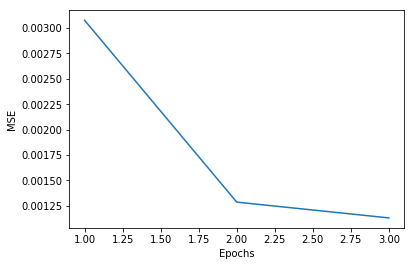

In [19]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [20]:
pre, act = evaluate_model(train, test, n_input,model)

1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 2ms/step


In [21]:
reshape_test = test.reshape([len(test)*length,2])
#去标准化，还原原值
inv_test = scaler.inverse_transform(reshape_test)


In [22]:
concat_test_pre = np.concatenate((pre.reshape([len(pre)*length,1]), test.reshape([len(test)*length,2])[:,-1 :]), axis=1)


In [23]:
concat_test_pre

array([[0.31110451, 0.25233645],
       [0.28585851, 0.24299065],
       [0.27485391, 0.22429907],
       ...,
       [0.38423771, 0.26168224],
       [0.3224782 , 0.23364486],
       [0.26491189, 0.24299065]])

In [24]:
inv_test

array([[13821.,    20.],
       [13280.,    19.],
       [12885.,    17.],
       ...,
       [15525.,    21.],
       [14759.,    18.],
       [14071.,    19.]])

In [25]:
inv_testsplit = array(split(inv_test, len(inv_test)/length))
inv_testsplit

array([[[1.3821e+04, 2.0000e+01],
        [1.3280e+04, 1.9000e+01],
        [1.2885e+04, 1.7000e+01],
        [1.2729e+04, 1.7000e+01],
        [1.2779e+04, 1.7000e+01],
        [1.3137e+04, 1.7000e+01]],

       [[1.3633e+04, 1.7000e+01],
        [1.3968e+04, 1.7000e+01],
        [1.4498e+04, 1.7000e+01],
        [1.5023e+04, 1.9000e+01],
        [1.5407e+04, 2.2000e+01],
        [1.5614e+04, 2.3000e+01]],

       [[1.5671e+04, 2.4000e+01],
        [1.5548e+04, 2.5000e+01],
        [1.5505e+04, 2.6000e+01],
        [1.5735e+04, 2.6000e+01],
        [1.7002e+04, 2.5000e+01],
        [1.8231e+04, 2.4000e+01]],

       ...,

       [[1.4850e+04, 1.7000e+01],
        [1.5829e+04, 1.7000e+01],
        [1.6430e+04, 1.8000e+01],
        [1.6614e+04, 2.1000e+01],
        [1.6602e+04, 2.4000e+01],
        [1.6445e+04, 2.6000e+01]],

       [[1.6240e+04, 2.8000e+01],
        [1.6052e+04, 2.8000e+01],
        [1.5919e+04, 2.8000e+01],
        [1.6014e+04, 2.8000e+01],
        [1.7075e+04, 2.7000

In [26]:
inv_testsplit_0 = inv_testsplit[:, :, 0]
inv_testsplit_0

array([[13821., 13280., 12885., 12729., 12779., 13137.],
       [13633., 13968., 14498., 15023., 15407., 15614.],
       [15671., 15548., 15505., 15735., 17002., 18231.],
       ...,
       [14850., 15829., 16430., 16614., 16602., 16445.],
       [16240., 16052., 15919., 16014., 17075., 18123.],
       [17708., 16955., 16243., 15525., 14759., 14071.]])

In [27]:
inv_pre = scaler.inverse_transform(concat_test_pre)


In [28]:
inv_pre

array([[13962.58015001,    20.        ],
       [13462.00257444,    19.        ],
       [13243.80342615,    17.        ],
       ...,
       [15412.66524768,    21.        ],
       [14188.09784806,    18.        ],
       [13046.67295551,    19.        ]])

In [29]:
inv_presplit = array(split(inv_pre, len(inv_pre)/length))
inv_presplit

array([[[1.39625802e+04, 2.00000000e+01],
        [1.34620026e+04, 1.90000000e+01],
        [1.32438034e+04, 1.70000000e+01],
        [1.30967535e+04, 1.70000000e+01],
        [1.30795695e+04, 1.70000000e+01],
        [1.33579137e+04, 1.70000000e+01]],

       [[1.38930980e+04, 1.70000000e+01],
        [1.51805422e+04, 1.70000000e+01],
        [1.60262298e+04, 1.70000000e+01],
        [1.63806260e+04, 1.90000000e+01],
        [1.65867084e+04, 2.20000000e+01],
        [1.66053023e+04, 2.30000000e+01]],

       [[1.54330999e+04, 2.40000000e+01],
        [1.52574033e+04, 2.50000000e+01],
        [1.51656026e+04, 2.60000000e+01],
        [1.54100061e+04, 2.60000000e+01],
        [1.57064815e+04, 2.50000000e+01],
        [1.62015204e+04, 2.40000000e+01]],

       ...,

       [[1.51494870e+04, 1.70000000e+01],
        [1.62122657e+04, 1.70000000e+01],
        [1.65406721e+04, 1.80000000e+01],
        [1.66928542e+04, 2.10000000e+01],
        [1.68113137e+04, 2.40000000e+01],
        [1.6805

In [30]:
inv_presplit_0 = inv_presplit[:, :, 0]
inv_presplit_0

array([[13962.58015001, 13462.00257444, 13243.80342615, 13096.75346351,
        13079.56949687, 13357.91371024],
       [13893.09795094, 15180.54224086, 16026.22976756, 16380.62603354,
        16586.70835805, 16605.30226088],
       [15433.0998677 , 15257.40326357, 15165.60259008, 15410.00610566,
        15706.48153114, 16201.52040935],
       ...,
       [15149.48700762, 16212.26570678, 16540.6721096 , 16692.85421634,
        16811.31367493, 16805.81043279],
       [16172.66576385, 15950.74440765, 15900.30816555, 16271.37547922,
        16621.30320477, 17129.36892426],
       [17763.65761518, 17226.84361589, 16451.38048434, 15412.66524768,
        14188.09784806, 13046.67295551]])

In [31]:
score, scores = evaluate_forecasts(inv_testsplit_0, inv_presplit_0)
summarize_scores('cnn', score, scores)

cnn: [570.303] 237.7, 435.2, 451.9, 553.7, 701.3, 838.4
